In [507]:
from datetime import datetime, timedelta
import pandas as pd
import glob, os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import datetime as dt 
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from matplotlib import pyplot as plt
from scipy import stats

In [508]:
# Read layer3-60 data from all the csv files 
path = r'C:/Users/jainsac/Downloads/MRP/Assignment 2/Data'
Resultpath= r'C:/Users/jainsac/Downloads/MRP/Assignment 2/Results/'
data = pd.concat(map(lambda file: pd.read_csv(file, header = None), glob.glob(os.path.join('', path+'/*.csv'))))
data.columns = ['StartTime', 'EndTime', 'Channel', 'Power_dbm','SNR', 'Occupancy']

In [509]:
# Copying the df to a new dataframe so that 
# future processing could be done easily
Temporaldf = data

In [510]:
chList = pd.read_csv('C:/Users/jainsac/Downloads/MRP/Assignment 2/ChannelList.csv', header=0, sep ='\t')

In [511]:
channel_list = chList.Channel.unique().tolist()

In [512]:
uniqueST = Temporaldf.StartTime.unique()
ST_df=pd.DataFrame(uniqueST, columns=['StartT']) 
TemporalDFInd = ST_df.set_index('StartT')
TempReindex = TemporalDFInd.reindex(pd.date_range(start=TemporalDFInd.index[0], end=TemporalDFInd.index[-1], freq='1h'))
reindexed = TempReindex.shape[0]

channelO = []
for ch in channel_list:
    TemporalDF = Temporaldf[(Temporaldf.Channel == ch)][['StartTime']]
    original = TemporalDF.shape[0]
    channelOcc = (original/reindexed)*100
    channelO.append(channelOcc)
    # Put channel and channelOcc in DF
temp_df = pd.DataFrame({'Channel': channel_list, 'perData': channelO})
dataThresh = np.percentile(channelO, 75)
temp_df = temp_df[temp_df['perData'] >= dataThresh]
temp_df = temp_df.loc[0:, (temp_df >= dataThresh).any(axis=0)]
channel_list = temp_df['Channel'].tolist()

In [513]:
# List of channels will override the final list until entire data is available
channel_list = [16010, 15820, 15540, 15530, 15570, 22490, 23480, 21340, 24220, 16130, 24670, 24890, 25410, 25810, 24530,26030, 29310, 28150,
                31020, 27710, 34700, 50132, 50193, 31780, 50175, 50271, 50280, 50269, 50259, 50285, 50309, 50617, 50361, 50295, 50287, 50659, 
                50677, 51028, 50673, 51085, 51095, 51119, 51111, 51224, 51086, 53112, 51292, 51272, 53236, 53144, 10670, 11720, 11710, 10930, 
                2340, 15420, 15990, 50969, 12040, 29990, 11870, 15220, 15130, 13300, 13520, 51366, 53334, 53333, 51176, 51026, 54494, 53970, 
                53379, 54006, 53442, 54620, 56303, 56304, 56293, 56097, 56305, 56306, 56307, 56308, 56333, 56350, 56352, 56353, 56354, 56355, 
                56360, 56356, 56357, 56358, 56359, 1370, 3860, 830, 2020, 131, 11830, 11840, 11860, 9230, 11800, 55232, 55240, 55292, 55293,
                55338, 55355, 55361, 55372, 55410, 55417, 55457, 55481, 55482, 55508, 55510, 55520, 55639, 55640, 55678, 55692, 55713, 55797,
                55858, 55902, 55920, 55922, 56033, 56181, 56230, 56232, 56283, 56294, 56295, 56296, 56300, 56301, 56322, 56323, 56324, 56325,
                56334, 56340, 56341, 56342, 56343
               ]

In [514]:
merged = pd.merge(temp_df,data, on=['Channel','Channel'])
# Dropping the data point if null value is encountered in 
# Occupancy, Power_dbm or SNR. how = 'any' is the default
# option which means if any of them is NA, drop the entire
# row of the data from the dataset. 
merged = merged.dropna(subset=['Occupancy', 'Power_dbm', 'SNR'], how='any')

In [515]:
TimeInducedDfOriginal = merged

In [516]:
TimeInducedDf = TimeInducedDfOriginal

In [517]:
thresh_list = []
f = 10
i = 0
while i<=10:
    thresh_list.append(f*i)
    i = i+1
print(thresh_list)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [518]:
#thresh_list = [80]
pValue = []
for fr in thresh_list:
    globalLR = []
    globalNB = []
    for ch in channel_list:
        LRaccuracy = []
        LRsensitivity = []
        LRspecificity = []
        LRfmeasure = []
        LRprecision = []
        NBaccuracy = []
        NBsensitivity = []
        NBspecificity = []
        NBfmeasure = []
        NBprecision = []
        FoldCount = []
        NumCount = []
        channelNum = []
        Threshold = []

        TimeInducedDf = TimeInducedDfOriginal[(TimeInducedDfOriginal.Channel == ch)][['StartTime', 'EndTime', 'Channel', 'Power_dbm','SNR', 'Occupancy']]
        TimeInducedDf['StartTimeIndex'] = TimeInducedDf['StartTime'].values.astype('<M8[h]')
        TimeInducedDf['EndTimeStrip'] = TimeInducedDf['EndTime'].values.astype('<M8[h]')
        TimeInducedDf = TimeInducedDf.drop(['StartTime', 'EndTime', 'Power_dbm', 'SNR'], 1)
        TimeInducedDf = TimeInducedDf[[ 'Channel','StartTimeIndex', 'EndTimeStrip','Occupancy']]
        TimeInducedDf = TimeInducedDf.set_index('StartTimeIndex')
        TimeInducedDf= TimeInducedDf.reindex(pd.date_range(start=TimeInducedDf.index[0], end=TimeInducedDf.index[-1], freq='1h'))
        TimeInducedDf[TimeInducedDf['Occupancy'].isnull()]
        k = 2
        TimeInducedDf['T1'] = TimeInducedDf['Occupancy'].shift()
        while k <=6:
            TimeInducedDf['T'+str(k)] = TimeInducedDf['T'+str(k-1)].shift()
            k=k+1
        # Convert index back to dataframe column
        TimeInducedDf.reset_index(level=0, inplace=True)

        # Remove NAs
        TimeInducedDf = TimeInducedDf.dropna(subset=['Occupancy', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'], how='any')
        TimeInducedDf['OccupancyClass'] = pd.cut(TimeInducedDf['Occupancy'], [-np.inf, fr, np.inf], labels=[0, 1])

        TimeInducedDFy = TimeInducedDf[(TimeInducedDf.Channel == ch)][['OccupancyClass']] 
        t = TimeInducedDFy.groupby('OccupancyClass').size()
        if (t[0] > 5 and t[1] > 5):
            #print(ch)
            #print(fr)
            # split the dataframe into two sets: x - attributes, y - response variables
            # in our case, y = Occupancy, x would be rest of the columns
            TimeInducedDFx = TimeInducedDf[(TimeInducedDf.Channel == ch)][['Channel', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']]

            # Insert a while loop to averager out the runs. value of numofruns = 10
            numOfRuns = 1
            while numOfRuns <= 10:

                numOfSplits = 10   
                # initialize variables for each channel
                n = len(TimeInducedDFx)
                fold = 0
                #for trainRatio in np.arange(0.05, 1, 0.05):
                kf = KFold(n_splits = numOfSplits, shuffle=True, random_state = 777)
                for train_idx, test_idx in kf.split(TimeInducedDFx, TimeInducedDFy):
                    X_trainNew, X_testNew = TimeInducedDFx.iloc[train_idx], TimeInducedDFx.iloc[test_idx]
                    y_trainNew, y_testNew = TimeInducedDFy.iloc[train_idx], TimeInducedDFy.iloc[test_idx]

                    fold += 1
                    FoldCount.append(fold)
                    NumCount.append(numOfRuns)

                    # Logistic Regression for reduced dataset
                    regr = LogisticRegression()                   
                    clf2 = regr.fit(X_trainNew, y_trainNew)
                    y_predNew = clf2.predict(X_testNew)
                    scoreLRRed = clf2.score(X_testNew, y_testNew)
                    LRaccuracy.append(scoreLRRed) 
                    globalLR.append(scoreLRRed)
                    cfm_LR = confusion_matrix(y_testNew, y_predNew, labels=[0,1])
                    
                    # Calculate sensitivity
                    sensitivityLR = cfm_LR[1,1]/(cfm_LR[1,0]+cfm_LR[1,1])
                    LRsensitivity.append(sensitivityLR)

                    # Calculate Specificity
                    specificityLR = cfm_LR[0,0]/(cfm_LR[0,0]+cfm_LR[0,1])
                    LRspecificity.append(specificityLR)
                    
                    # Calculate Precision
                    precisionLR = precision_score(y_testNew,y_predNew,average='weighted')
                    LRprecision.append(precisionLR)
                    
                    # Calculate f-measure
                    fmeasureLR = f1_score(y_testNew,y_predNew,average='weighted')
                    LRfmeasure.append(fmeasureLR)

                    # Naive Bayes for reduced dataset
                    modelRed = GaussianNB()
                    
                    # Train the model using the training sets 
                    modelRed.fit(X_trainNew, y_trainNew)
                    
                    #Predict Output 
                    predictedRed = modelRed.predict(X_testNew)
                    scoreNBRed = accuracy_score(y_testNew, predictedRed)
                    NBaccuracy.append(scoreNBRed)
                    globalNB.append(scoreNBRed)
                    

                    channelNum.append(ch)
                    Threshold.append(fr)

                    cfm_NB = confusion_matrix(y_testNew, predictedRed, labels=[0,1])
                    # Calculate sensitivity
                    sensitivityNB = cfm_NB[1,1]/(cfm_NB[1,0]+cfm_NB[1,1])
                    NBsensitivity.append(sensitivityNB)

                    # Calculate Specificity
                    specificityNB = cfm_NB[0,0]/(cfm_NB[0,0]+cfm_NB[0,1])
                    NBspecificity.append(specificityNB)
                    
                    # Calculate Precision
                    precisionNB = precision_score(y_testNew,predictedRed,average='weighted')
                    NBprecision.append(precisionNB)

                    # Calculate f-measure
                    fmeasureNB = f1_score(y_testNew,predictedRed,average='weighted')
                    NBfmeasure.append(fmeasureNB)
                    

                numOfRuns = numOfRuns + 1
                #print("Number of Runs: " + str(numOfRuns))
                #print("Lenght of LR: "+str(len(LRaccuracy)))
                #print("Length of NB: "+ str(len(NBaccuracy)))
            
            #p = stats.ttest_ind(LRaccuracy, NBaccuracy, nan_policy = 'omit')
            # Add the data to the csv
            #print(LRaccuracy)
            
            #print(NBaccuracy)
            #p = stats.ttest_ind(LRaccuracy, NBaccuracy, nan_policy = 'omit')
            #print(p)
            #print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            plc_df = pd.DataFrame({'Channel': channelNum,'Threshold': Threshold,  
                                   'NumCount':NumCount, 'Fold': FoldCount, 
                                   'LRaccuracy':LRaccuracy, 'NBaccuracy': NBaccuracy,
                                   'LRsensitivity':LRsensitivity,'NBsensitivity':NBsensitivity, 
                                   'LRspecificity':LRspecificity,'NBspecificity':NBspecificity,
                                   'LRprecision': LRprecision, 'NBprecision':NBprecision,
                                   'NBfmeasure':NBfmeasure, 'LRfmeasure':LRfmeasure
                                  })
            plc_df.to_csv(Resultpath+'Output-Baseline.csv', header=False,sep='\t', encoding='utf-8', index=False, mode = 'a')
    #print(fr)
    #print(np.isnan(LRaccuracy))
    #LRaccuracy = [lr for lr in LRaccuracy if float(lr) != 'nan']
    #print(len(globalLR))
    
    #print(len(globalNB))
    #print("*******************************")
    #NBaccuracy = [nb for nb in LRaccuracy if float(nb) != 'nan']
    #print(np.isnan(NBaccuracy))
    p = stats.ttest_ind(globalLR[0:50], globalNB[0:50])
    #print(p)
    pValue.append(p[1])


In [519]:
pValue

[nan,
 1.9743380842042764e-20,
 0.0002752770840605459,
 5.476076738589158e-08,
 0.0003567657776610458,
 0.00014662738724600317,
 3.67986762771207e-45,
 1.5261944873441172e-05,
 2.467062258757745e-45,
 9.941718482290623e-16,
 nan]

In [520]:
read_plc = pd.read_csv(Resultpath+'Output-Baseline.csv', header=1, sep ='\t')

In [521]:
read_plc.columns = ['Channel','Fold','LRaccuracy', 'LRfmeasure', 
                    'LRprecision', 'LRsensitivity', 'LRspecificity', 
                    'NBaccuracy',' NBfmeasure', 'NBsensitivity',
                    'NBspecificity','NBprecision',
                    'NumCount', 'Threshold']

In [522]:
read_plc.head()

,Channel,Fold,LRaccuracy,LRfmeasure,LRprecision,LRsensitivity,LRspecificity,NBaccuracy,NBfmeasure,NBsensitivity,NBspecificity,NBprecision,NumCount,Threshold
0,15820,3,0.897959,0.877775,0.872558,0.977273,0.200000,0.714286,0.770592,0.924812,0.681818,1.000000,1,10
1,15820,4,0.938776,0.909130,0.881299,1.000000,0.000000,0.755102,0.818367,0.951020,0.739130,1.000000,1,10
2,15820,5,0.857143,0.791209,0.734694,1.000000,0.000000,0.755102,0.789575,0.880777,0.738095,0.857143,1,10
3,15820,6,0.877551,0.877551,0.877551,0.933333,0.250000,0.795918,0.836984,0.913955,0.800000,0.750000,1,10
4,15820,7,0.854167,0.832375,0.819444,0.952381,0.166667,0.729167,0.774789,0.914474,0.690476,1.000000,1,10


In [523]:
read_plc = read_plc.drop('NumCount', 1)
read_plc = read_plc.drop('Fold', 1)

In [524]:
ExtendedResultsDF = read_plc.groupby(['Channel','Threshold']).mean().add_suffix('_avg').reset_index()

In [ ]:
ExtendedResultsDF

In [526]:
# Write the results to a CSV
ExtendedResultsDF.to_csv(Resultpath+'ExtendedResults-Baseline.csv', header=False,sep='\t', index=False)

In [527]:
# Create a subset copy with two columns: channels and threshold
ExtendedResultsDFTemp = ExtendedResultsDF[['Channel', 'Threshold']] 

# count the number of channels in each threshold
ExtendedResultsDFTemp = ExtendedResultsDFTemp.groupby(['Threshold']).count().reset_index()


In [528]:
read_plc = read_plc.drop('Channel', 1)

In [529]:
CompactResultsDF = read_plc.groupby(['Threshold']).mean().add_suffix('_avg').reset_index()

In [530]:
# Inner join channels
CompactResultsDFFinal = pd.merge(CompactResultsDF,ExtendedResultsDFTemp, on=['Threshold','Threshold'])

In [531]:
CompactResultsDFFinal

,Threshold,LRaccuracy_avg,LRfmeasure_avg,LRprecision_avg,LRsensitivity_avg,LRspecificity_avg,NBaccuracy_avg,NBfmeasure_avg,NBsensitivity_avg,NBspecificity_avg,NBprecision_avg,Channel
0,10,0.923303,0.918903,0.923356,0.880814,0.727206,0.837658,0.846804,0.894372,0.760796,0.857168,117
1,20,0.918149,0.914545,0.919446,0.851617,0.822070,0.865419,0.871887,0.895223,0.801515,0.873177,134
2,30,0.924521,0.921193,0.925099,0.831660,0.866108,0.882343,0.887001,0.901445,0.822260,0.877937,142
3,40,0.931449,0.928455,0.931016,0.811388,0.887433,0.887519,0.893122,0.907048,0.826972,0.874584,147
4,50,0.937576,0.934460,0.936209,0.783985,0.898388,0.897129,0.903667,0.918306,0.835563,0.880499,149
5,60,0.944336,0.941207,0.942566,0.750369,0.911073,0.903129,0.911646,0.928714,0.833835,0.881017,146
6,70,0.951295,0.948582,0.949839,0.742233,0.915327,0.909249,0.918939,0.936847,0.834856,0.880759,139
7,80,0.955566,0.953109,0.954184,0.753089,0.922223,0.914751,0.924135,0.941063,0.840378,0.891026,123
8,90,0.952692,0.950923,0.952541,0.800912,0.912400,0.918636,0.924848,0.937600,0.858954,0.888447,99


In [ ]:
pValue

In [533]:
pValue = pValue[1:(len(pValue)-1)]

In [534]:
CompactResultsDFFinal['TimeResolution'] = '60min'
CompactResultsDFFinal['pValue'] = pValue

In [535]:
#pValue = [pV for pV in pValue if str(pV) != 'nan']

In [536]:
#PVal = float(sum(pValue)) / max(len(pValue), 1)

In [537]:
CompactResultsDFFinal.head()

,Threshold,LRaccuracy_avg,LRfmeasure_avg,LRprecision_avg,LRsensitivity_avg,LRspecificity_avg,NBaccuracy_avg,NBfmeasure_avg,NBsensitivity_avg,NBspecificity_avg,NBprecision_avg,Channel,TimeResolution,pValue
0,10,0.923303,0.918903,0.923356,0.880814,0.727206,0.837658,0.846804,0.894372,0.760796,0.857168,117,60min,1.974338e-20
1,20,0.918149,0.914545,0.919446,0.851617,0.822070,0.865419,0.871887,0.895223,0.801515,0.873177,134,60min,2.752771e-04
2,30,0.924521,0.921193,0.925099,0.831660,0.866108,0.882343,0.887001,0.901445,0.822260,0.877937,142,60min,5.476077e-08
3,40,0.931449,0.928455,0.931016,0.811388,0.887433,0.887519,0.893122,0.907048,0.826972,0.874584,147,60min,3.567658e-04
4,50,0.937576,0.934460,0.936209,0.783985,0.898388,0.897129,0.903667,0.918306,0.835563,0.880499,149,60min,1.466274e-04


In [538]:
# Write the results to a CSV
CompactResultsDFFinal.to_csv(Resultpath+'CompactResults-Baseline.csv', header=False,sep='\t', index=False, mode = 'a')

In [539]:
CompactResultsDFFinal['LRXaxis'] = 1 - CompactResultsDFFinal['LRspecificity_avg']

In [540]:
CompactResultsDFFinal['NBXaxis'] = 1 - CompactResultsDFFinal['NBspecificity_avg']

#### Above table indicates average of performance measure per Threshold. 

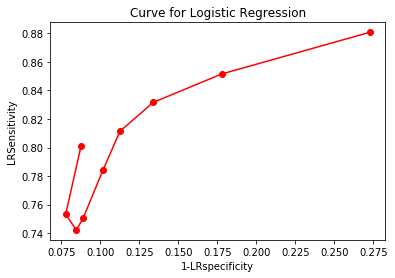

In [541]:
plt.plot(CompactResultsDFFinal['LRXaxis'],CompactResultsDFFinal['LRsensitivity_avg'], '-o', color='red')
plt.ylabel('LRSensitivity')
plt.xlabel('1-LRspecificity')
plt.title('Curve for Logistic Regression')
plt.show()

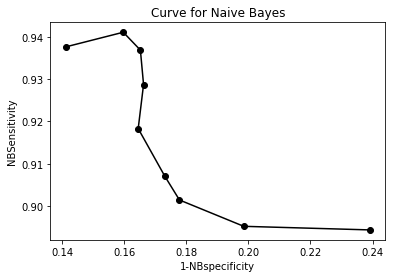

In [542]:
plt.plot(CompactResultsDFFinal['NBXaxis'],CompactResultsDFFinal['NBsensitivity_avg'], '-o',  color='black')
plt.ylabel('NBSensitivity')
plt.xlabel('1-NBspecificity')
plt.title('Curve for Naive Bayes')
plt.show()

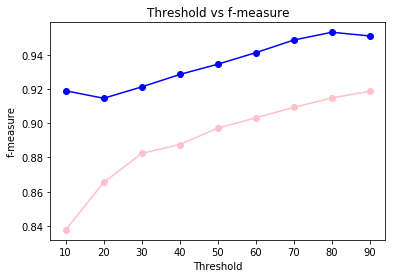

In [543]:
plt.plot(CompactResultsDFFinal['Threshold'],CompactResultsDFFinal['LRfmeasure_avg'], '-o', color = 'blue')
plt.plot(CompactResultsDFFinal['Threshold'],CompactResultsDFFinal[CompactResultsDFFinal.columns[6]], '-o', color = 'pink')
plt.ylabel('f-measure')
plt.xlabel('Threshold')
plt.title('Threshold vs f-measure')
plt.show()

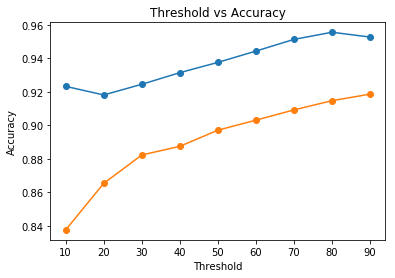

In [544]:
plt.plot(CompactResultsDFFinal['Threshold'],CompactResultsDFFinal['LRaccuracy_avg'], '-o')
plt.plot(CompactResultsDFFinal['Threshold'],CompactResultsDFFinal['NBaccuracy_avg'], '-o')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Threshold vs Accuracy')
plt.show()

In [553]:
finalResult = pd.read_csv(Resultpath+'CompactResults-Baseline.csv', header=None, sep ='\t')
#finalResult['pValue'] = PVal

In [554]:
finalResult

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,10,0.923303,0.918903,0.923356,0.880814,0.727206,0.837658,0.846804,0.894372,0.760796,0.857168,117,60min,1.974338e-20
1,20,0.918149,0.914545,0.919446,0.851617,0.822070,0.865419,0.871887,0.895223,0.801515,0.873177,134,60min,2.752771e-04
2,30,0.924521,0.921193,0.925099,0.831660,0.866108,0.882343,0.887001,0.901445,0.822260,0.877937,142,60min,5.476077e-08
3,40,0.931449,0.928455,0.931016,0.811388,0.887433,0.887519,0.893122,0.907048,0.826972,0.874584,147,60min,3.567658e-04
4,50,0.937576,0.934460,0.936209,0.783985,0.898388,0.897129,0.903667,0.918306,0.835563,0.880499,149,60min,1.466274e-04
5,60,0.944336,0.941207,0.942566,0.750369,0.911073,0.903129,0.911646,0.928714,0.833835,0.881017,146,60min,3.679868e-45
6,70,0.951295,0.948582,0.949839,0.742233,0.915327,0.909249,0.918939,0.936847,0.834856,0.880759,139,60min,1.526194e-05
7,80,0.955566,0.953109,0.954184,0.753089,0.922223,0.914751,0.924135,0.941063,0.840378,0.891026,123,60min,2.467062e-45
8,90,0.952692,0.950923,0.952541,0.800912,0.912400,0.918636,0.924848,0.937600,0.858954,0.888447,99,60min,9.941718e-16
9,80,0.855949,0.842205,0.849854,0.673719,0.837692,0.832254,0.833040,0.859188,0.720364,0.818288,75,6hours,1.142061e-03


In [555]:
finalResult.columns = ['Threshold', 'LRaccuracy', 'LRprecision','NBaccuracy', 
                       'LRsensitivity', 'NBsensitivity', 'LRspecificity', 
                       'NBspecificity', 'LRfmeasure', 'NBfmeasure', 'NBprecision', 
                       'ChannelCount', 'TimeResolution', 'pValue']

In [556]:
finalResult = finalResult[(finalResult['Threshold'] == 80)]

In [557]:
finalResult

,Threshold,LRaccuracy,LRprecision,NBaccuracy,LRsensitivity,NBsensitivity,LRspecificity,NBspecificity,LRfmeasure,NBfmeasure,NBprecision,ChannelCount,TimeResolution,pValue
7,80,0.955566,0.953109,0.954184,0.753089,0.922223,0.914751,0.924135,0.941063,0.840378,0.891026,123,60min,2.467062e-45
9,80,0.855949,0.842205,0.849854,0.673719,0.837692,0.832254,0.833040,0.859188,0.720364,0.818288,75,6hours,1.142061e-03
10,80,0.968159,0.966296,0.966694,0.743111,0.949789,0.928389,0.937687,0.953836,0.876859,0.912954,124,30min,9.901751e-23
11,80,0.974258,0.972364,0.973216,0.763191,0.959702,0.936931,0.946371,0.962431,0.904602,0.925813,132,15min,7.604045e-55
